In [ ]:
import pandas as pd
import idx2numpy
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import expit,logit
from copy import deepcopy

trainFile = r".\train-images.idx3-ubyte"
labelFile = r".\train-labels.idx1-ubyte"
train = idx2numpy.convert_from_file(trainFile)#simple import (took me half an hour)
label = idx2numpy.convert_from_file(labelFile)

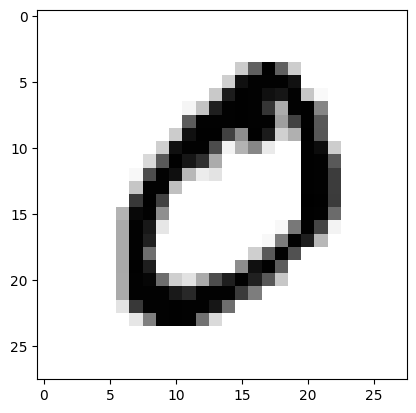

0


In [ ]:
plt.imshow(train[1], cmap=plt.cm.binary)
plt.show()
print(label[1])

In [ ]:
from abc import ABC,abstractmethod
class Network(): #refer to the "documentation" buried within my notes
                #vectorized implementation of a basic neural networks
                #TODO add support for other cost functions/activaiton functions
                #TODO add support for deleting layers
    class Layer():

        def __init__(self,network,nodeCount,activationClass,nodePreviousLayer=0):#keep node connections as an array for better performance(to avoid member access overhead)

            self.network = network
            self._layerCount = len(network._layers)

            self._nodeArray = np.zeros(nodeCount,float)#node array

            

            if(nodePreviousLayer):#if this is not the input layer

                self._activation = activationClass._activation #customizable activation function
                self._dActivation = activationClass._dActivation

                self._weightArray = np.random.rand(nodeCount,len(nodePreviousLayer._nodeArray)) #incoming weights array row = node to go in, column = weights of the node in
                self._biasArray = np.zeros(nodeCount)#bias array

                self._dBiasArray = np.zeros(nodeCount,float)#derivative of bias
                self._dWeightArray = np.zeros([nodeCount, len(nodePreviousLayer._nodeArray)], float)  # derivative of incoming weights
                self._dNodeArray = np.zeros(nodeCount,float)#delta array of ∂Activation/∂Node (refer to documentation)
                                                            #node = w*incoming + bias
                self._prevLayer = nodePreviousLayer #array of previous layer's data #DANGER MAKE SURE IT IS PASSING BY REFERENCE
                self._nextLayer : self.Layer #array of next layer's data, assigend/refreshed on connect()

        def _forwardProp(self): #TODO change this to support other activation functions
            self._nodeArray = np.matmul(self._weightArray,self._prevLayer._nodeArray)+self._biasArray
            self._nodeArray = self._activation(self._nodeArray)
            
        def _backProp(self,isLast = False):#backprop detail refer to "documentation"
            
            if(isLast):#is the last layer
                self._dNodeArray = self.network._dCostFunction(self.network._desiredOutput,self._nodeArray) 

            else:# is any other layer 
                self._dNodeArray = np.matmul(self._nextLayer._weightArray.T,self._nextLayer._dNodeArray)#the summation (should) is already in matrix multiplication
                self._dNodeArray = np.multiply(self._dNodeArray,self._dActivation(self._nodeArray))
            temp = np.transpose(self._weightArray)
            temp = temp*np.atleast_2d(self._prevLayer._nodeArray).T#I HAVE NO IDEA IF THIS IS CORECT OR NOT HELP
            self._dWeightArray += np.transpose(temp)*np.atleast_2d(self._dNodeArray).T# THIS IS SO GOING TO BUG ( it didnt yet i think)
            self._dBiasArray += self._dNodeArray#this one is simple tho yay

        def _optimize(self,learningRate):
            self._weightArray = self._weightArray - self._dWeightArray*learningRate/self.network.totalTrainData
            self._biasArray = self._biasArray - self._dBiasArray*learningRate/self.network.totalTrainData
            self._nodeArray = self._nodeArray*0

        
    class Activation(ABC):

        @abstractmethod
        def _activation(self, inArray):
            pass

        @abstractmethod
        def _dActivation(self, inArray):
            pass
    
    class Sigmoid(Activation):
        def _activation(self, inArray):  # sigmoid function
            return expit(inArray)

        # derivative for the sigmoid, this function takes in the activated output of the layer
        def _dActivation(self, inArray):
            return np.multiply(inArray, 1-inArray)
    
    class Relu(Activation):

        def _activation(self, inArray):
            return np.maximum(inArray,0)
        
        def _dActivation(self, inArray):
            return inArray > 0
    
    
    # class Softmax(Activation):
    #     def _activation(self, inArray):
    #         return np.exp(inArray)/np.sum(np.exp(inArray))
    #     def _dActivation(self, inArray):
    #         return super()._dActivation(inArray)
    

    class MAE():
        def _costFunction(self, desired, output):  # cost function, Mean squared error
            return np.sum(np.absolute(desired - output))

        def _dCostFunction(self, desired, output):
            return np.sign(desired - output)

    _layers = []
    _desiredOutput = []#cached for use in backprop
    totalTrainData = 0

    def __init__(self, startCount):#start count initializes the first layer
        self._layers = []
        self._layers.append(self.Layer(self,startCount))

    def addLayer(self,nodeCount,activationClass:Activation):#public interface to add new layers (not counting the starting layer)
        self._layers.append(self.Layer(self,nodeCount,self._layers[-1]),activationClass)

    def setInputLayer(self,inputData):#public interface to set first layer data
        self._layers[0]._nodeArray = inputData.copy() 

    def setCostFunction(self,costClass):
        self._costFunction = costClass._costFunction
        self._dCostFunction = costClass._dCostFunction

    def connect(self): # connects all layers to the next one except first/last one
        for i in range(len(self._layers)-2):
            self._layers[i+1]._nextLayer = self._layers[i+2]

    def trainNetwork(self,desiredAnswer,answer=False):
        self._desiredOutput = desiredAnswer.copy()#cached for use in backprop

        for i in range(len(self._layers)-1):
            self._layers[i+1]._forwardProp()
            
        if(answer):
            return self._layers[-1]._nodeArray
        
        for i in range(len(self._layers)-1):
            self._layers[-i-1]._backProp(True if i == 0 else False)#tell the function that its the last and not to access the out of index element


    def optimizeNetwork(self,learningRate):
        temp = self._costFunction(self._desiredOutput,self._layers[-1]._nodeArray)
        print(temp)
        for i in range(len(self._layers)-1):
            self._layers[i+1]._optimize(learningRate)

        return temp

    def getResult(self, desiredAnswerNodes):#calculate the cost
        outputNodes=self._layers[-1]._nodeArray
        return self._costFunction(desiredAnswerNodes,outputNodes)
    
    def _costFunction(self, desired, output):#cost function, Mean squared error
        print("uh oh stinky")
    
    def _dCostFunction(self, desired, output):
        print("uh oh stinky")

In [ ]:
network = Network(784)
network.addLayer(256, Network.Relu)
network.addLayer(256, Network.Relu)
network.addLayer(10, Network.Relu)
network.connect()
network.setCostFunction(Network.MAE)
batch = 2
epoch = 1000
result = []
network.totalTrainData = batch*epoch

for ii in range(epoch):
    for i in range(batch):
        network.setInputLayer(train[i+(ii* batch)].flatten())
        hotEncode = np.zeros(10)
        hotEncode[label[i+(ii*batch)]] = 1
        network.trainNetwork(hotEncode)
    result.append(network.optimizeNetwork(0.05))

network.setInputLayer(train[1].flatten())
hotEncode = np.zeros(10)
hotEncode[label[1]] = 1
print(network.trainNetwork(hotEncode,True))

plt.imshow(train[1], cmap=plt.cm.binary)
plt.show()

plt.plot(result)     

NameError: name 'Network' is not defined